In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import month_abbr
from datetime import datetime

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

<h3>Understanding the Customer and Product </h3>

---




Key Insights:
Average Monthly Spending: $53076.58
Max Customer Tenure: 1061 days
Average Lifetime Value: $3467.31
Top Region: South America
Customers by Region: {'Asia': 44, 'Europe': 50, 'North America': 46, 'South America': 59}
Average Transaction Value: $690.00


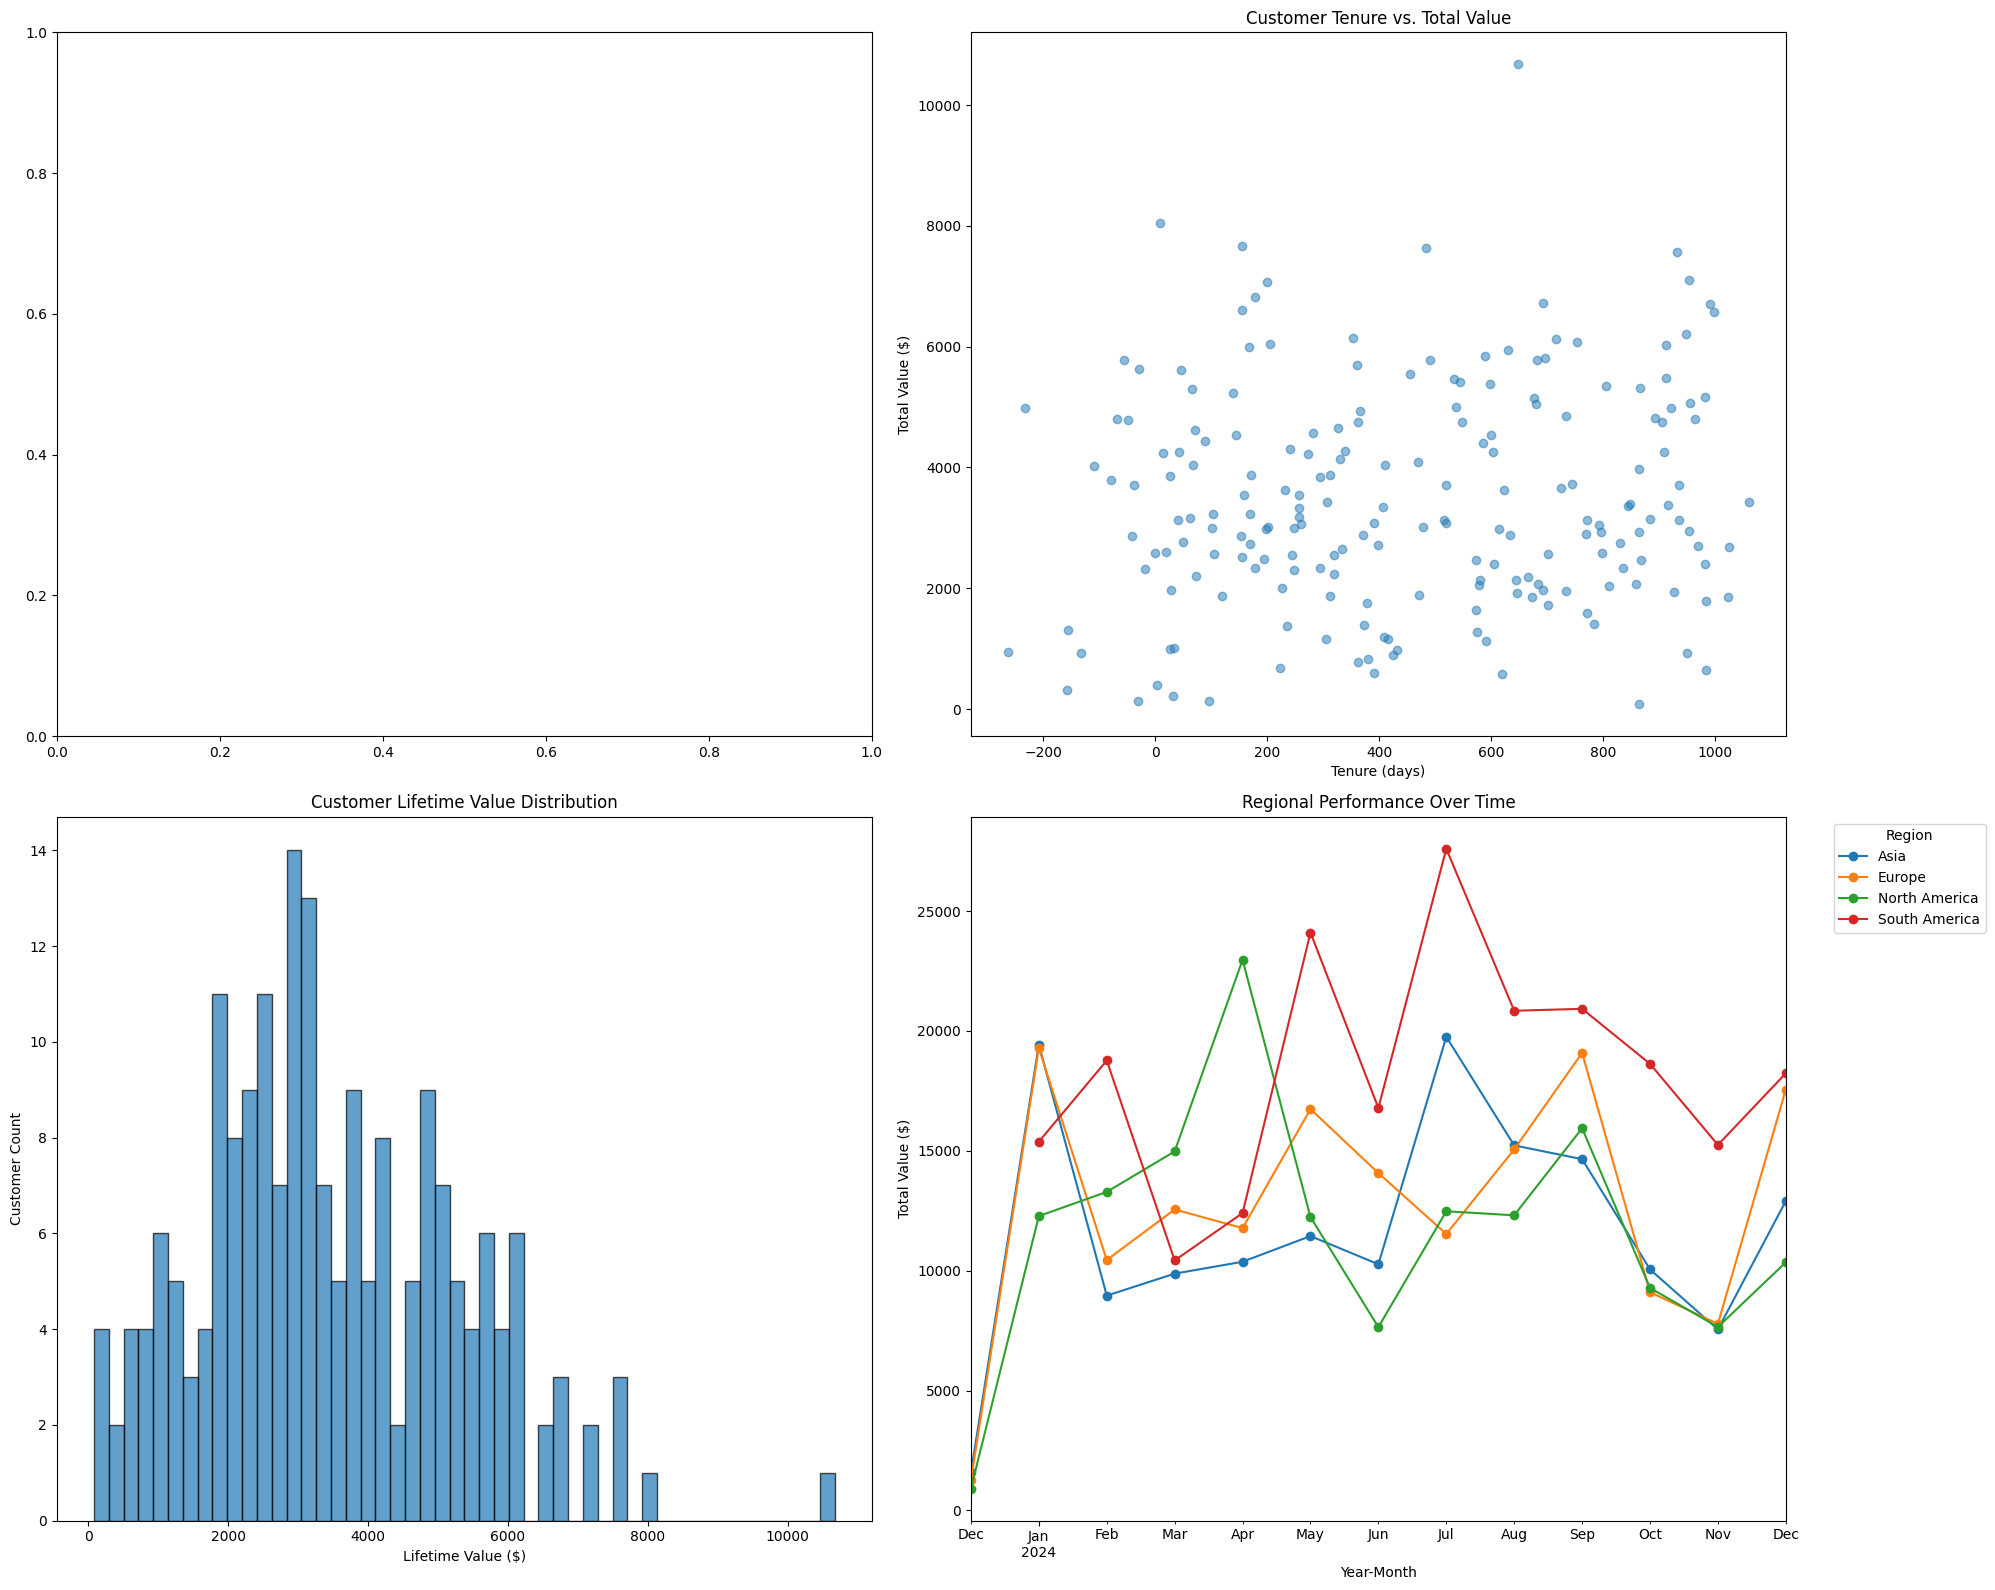

In [5]:
# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets on CustomerID
data = pd.merge(transactions, customers, on='CustomerID', how='left')

# Compute customer tenure in days
data['CustomerTenure'] = (data['TransactionDate'] - data['SignupDate']).dt.days

def analyze_customer_tenure():
    metrics = data.groupby('CustomerID').agg({
        'CustomerTenure': 'max',
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()

    # Avoid division by zero
    metrics['AvgMonthlyValue'] = metrics['TotalValue'] / (metrics['CustomerTenure'] / 30).replace(0, np.nan)

    return metrics

def analyze_regional_performance():
    data['YearMonth'] = data['TransactionDate'].dt.to_period('M')

    performance = data.groupby(['Region', 'YearMonth']).agg({
        'TotalValue': 'sum',
        'CustomerID': 'nunique'
    }).reset_index()

    return performance

# Compute monthly spending
monthly_spending = data.groupby(data['TransactionDate'].dt.to_period('M')).agg({'TotalValue': 'sum'}).reset_index()

def create_visualizations(monthly_spending, customer_metrics, regional_performance):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    axes[0, 1].scatter(customer_metrics['CustomerTenure'], customer_metrics['TotalValue'], alpha=0.5)
    axes[0, 1].set_title('Customer Tenure vs. Total Value')
    axes[0, 1].set_xlabel('Tenure (days)')
    axes[0, 1].set_ylabel('Total Value ($)')

    axes[1, 0].hist(customer_metrics['TotalValue'], bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Customer Lifetime Value Distribution')
    axes[1, 0].set_xlabel('Lifetime Value ($)')
    axes[1, 0].set_ylabel('Customer Count')

    pivot = regional_performance.pivot(index='YearMonth', columns='Region', values='TotalValue')
    pivot.plot(ax=axes[1, 1], marker='o')
    axes[1, 1].set_title('Regional Performance Over Time')
    axes[1, 1].set_xlabel('Year-Month')
    axes[1, 1].set_ylabel('Total Value ($)')
    axes[1, 1].legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return fig

def calculate_insights(monthly_spending, customer_metrics, regional_performance):
    insights = {
        'Average Monthly Spending': f"${monthly_spending['TotalValue'].mean():.2f}",
        'Max Customer Tenure': f"{customer_metrics['CustomerTenure'].max()} days",
        'Average Lifetime Value': f"${customer_metrics['TotalValue'].mean():.2f}",
        'Top Region': regional_performance.groupby('Region')['TotalValue'].sum().idxmax(),
        'Customers by Region': data.groupby('Region')['CustomerID'].nunique().to_dict(),
        'Average Transaction Value': f"${data['TotalValue'].mean():.2f}"
    }
    return insights

# Run analysis functions
customer_metrics = analyze_customer_tenure()
regional_performance = analyze_regional_performance()
fig = create_visualizations(monthly_spending, customer_metrics, regional_performance)
insights = calculate_insights(monthly_spending, customer_metrics, regional_performance)

# Print insights
print("\nKey Insights:")
for key, value in insights.items():
    print(f"{key}: {value}")


<h3>Find the category-wise top sold products</h3>


Significant Insights on Product Sales:

1. Top 5 Products Overall (By Sales Volume):
1. ActiveWear Textbook (Books) - Sold: 38, Revenue: $11,296.11
2. ActiveWear Smartwatch (Electronics) - Sold: 38, Revenue: $14,226.61
3. SoundWave Headphones (Electronics) - Sold: 37, Revenue: $9,479.35
4. ActiveWear Rug (Home Decor) - Sold: 30, Revenue: $7,488.25
5. HomeSense Desk Lamp (Home Decor) - Sold: 29, Revenue: $5,731.14

2. Best Products in Each Category:

Electronics: ActiveWear Smartwatch, Units Sold: 38, Revenue: $14,226.61

Clothing: HomeSense T-Shirt, Units Sold: 28, Revenue: $3,857.04

Books: ActiveWear Textbook, Units Sold: 38, Revenue: $11,296.11

Home Decor: ActiveWear Rug, Units Sold: 30, Revenue: $7,488.25

3. Top Products in Each Region:

Europe: ActiveWear Rug (Home Decor), Units Sold: 30, Revenue: $7,488.25

Asia: HomeSense T-Shirt (Clothing), Units Sold: 28, Revenue: $3,857.04

South America: ActiveWear Textbook (Books), Units Sold: 38, Revenue: $11,296.11

North America: Soun

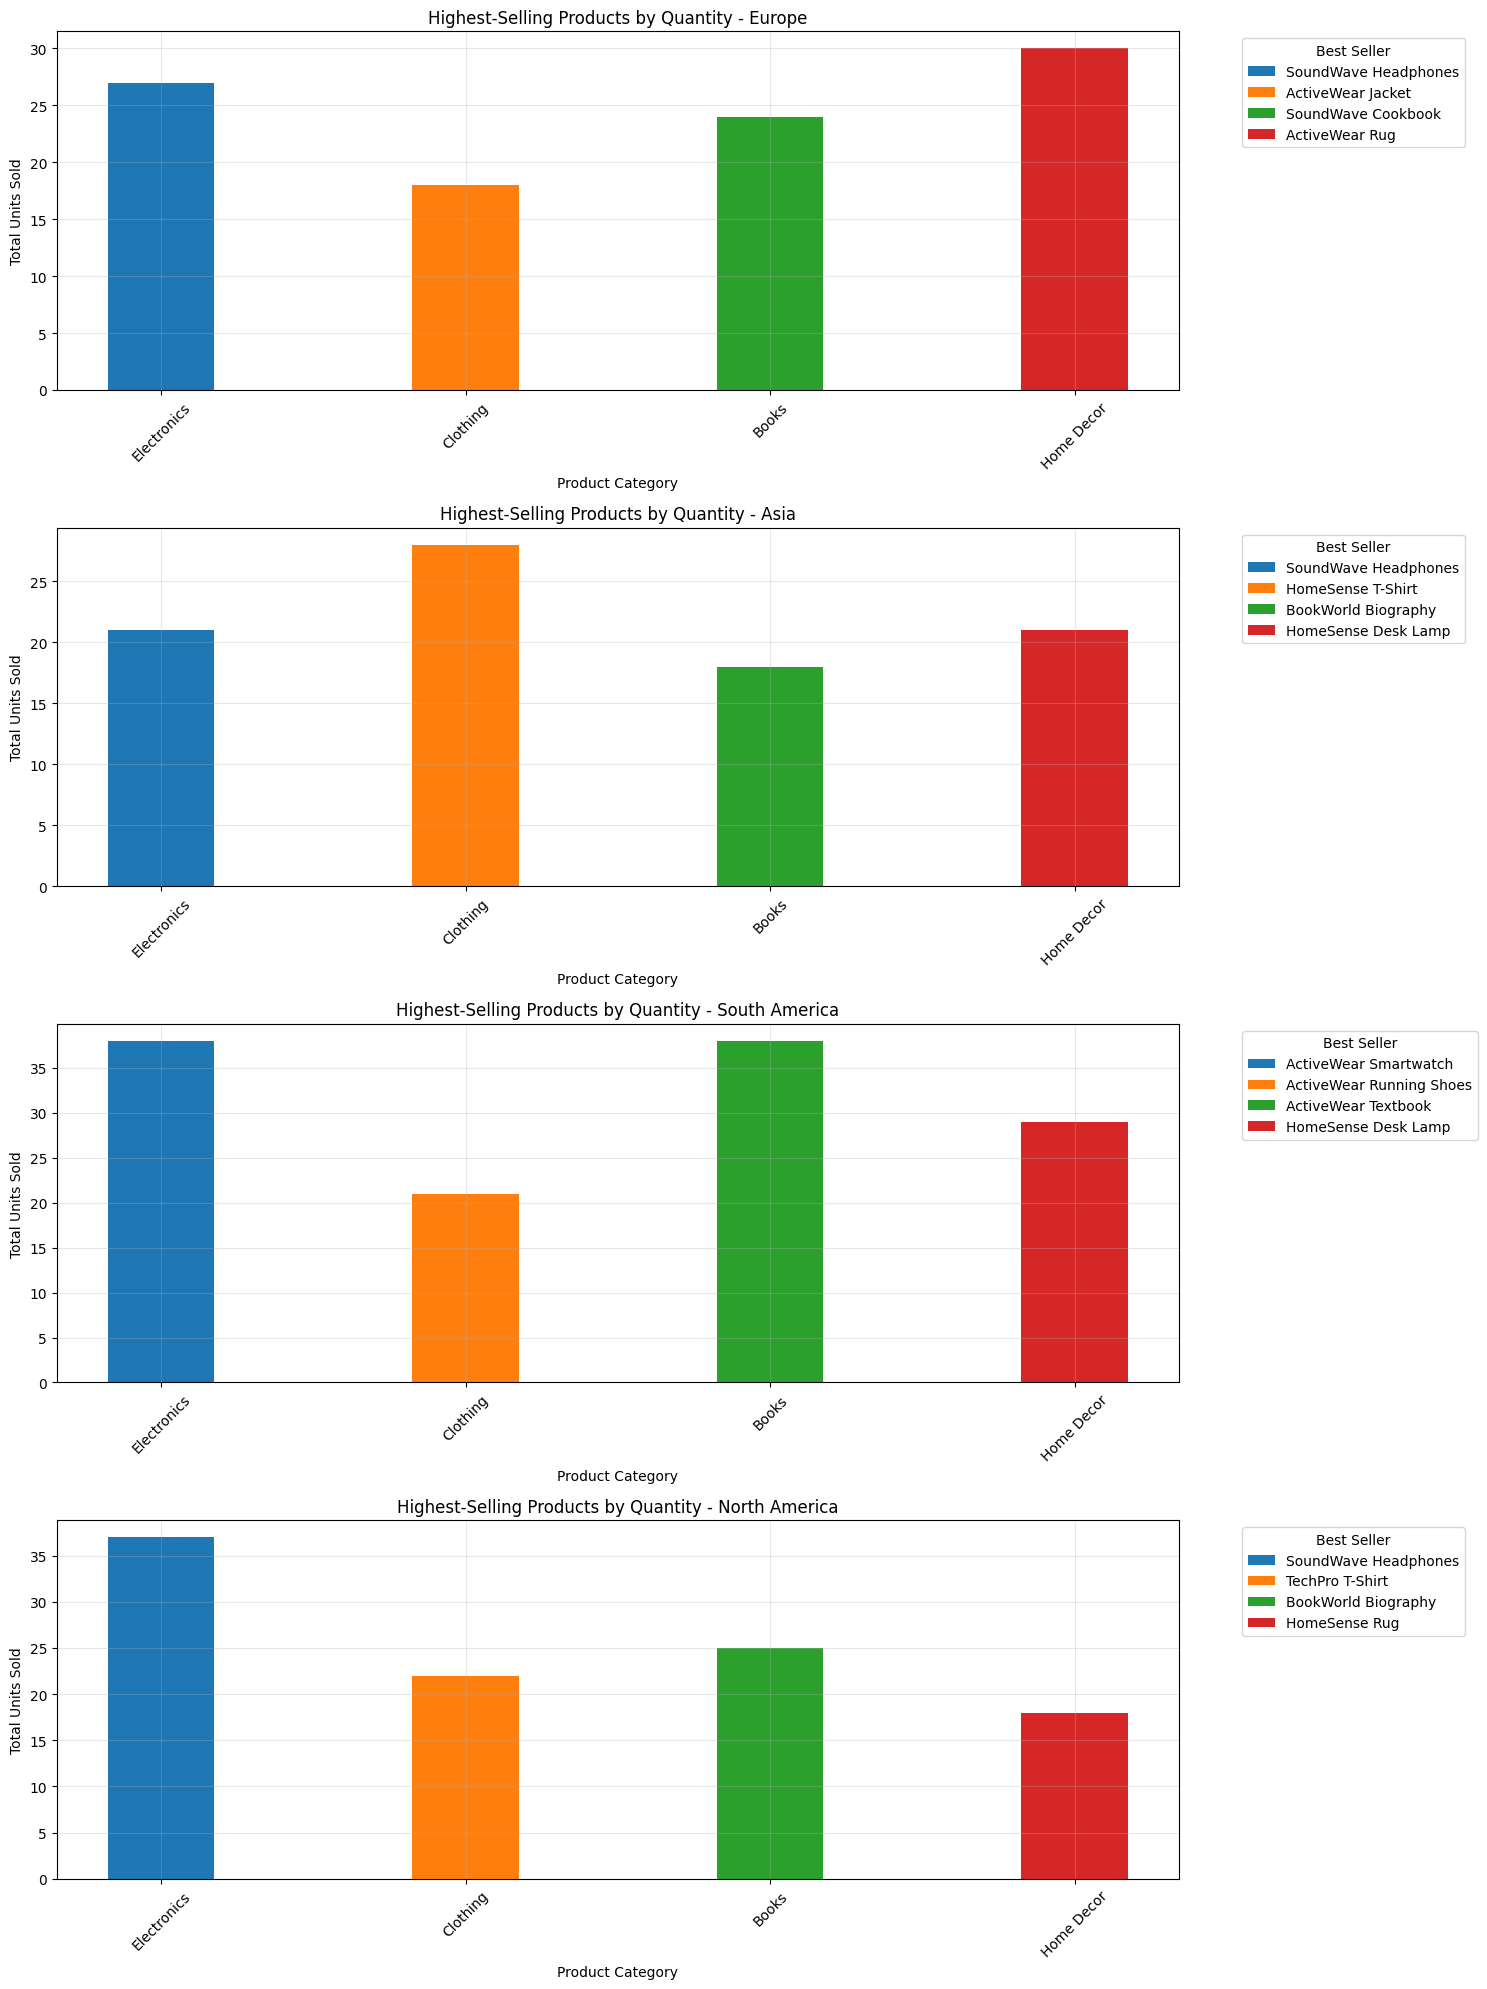

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_and_check_data():
    client_data = pd.read_csv('Customers.csv')
    product_catalog = pd.read_csv('Products.csv')
    sales_records = pd.read_csv('Transactions.csv')

    required_fields = {
        'client_data': ['CustomerID', 'Region'],
        'product_catalog': ['ProductID', 'ProductName', 'Category'],
        'sales_records': ['TransactionID', 'CustomerID', 'ProductID', 'Quantity', 'TotalValue']
    }

    for dataset_name, fields in required_fields.items():
        dataset = locals()[dataset_name]
        missing_fields = [field for field in fields if field not in dataset.columns]
        if missing_fields:
            raise KeyError(f"The following columns are missing from {dataset_name}: {missing_fields}")

    merged_data = sales_records.merge(client_data, on='CustomerID', how='left')\
                               .merge(product_catalog, on='ProductID', how='left')

    relevant_columns = ['Region', 'Category', 'ProductName', 'Quantity', 'TotalValue']
    missing_values = merged_data[relevant_columns].isnull().sum()
    if missing_values.any():
        merged_data['Region'].fillna('Unspecified Region', inplace=True)
        merged_data['Category'].fillna('Unclassified', inplace=True)
        merged_data['ProductName'].fillna('Unnamed Product', inplace=True)
        merged_data['Quantity'].fillna(0, inplace=True)
        merged_data['TotalValue'].fillna(0, inplace=True)

    return merged_data

def evaluate_best_sellers(merged_data):
    performance_summary = merged_data.groupby(['Region', 'Category', 'ProductName'], observed=True).agg({
        'Quantity': 'sum',
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()

    top_by_units = pd.concat([
        performance_summary[(performance_summary['Region'] == area) &
                            (performance_summary['Category'] == segment)].nlargest(5, 'Quantity')
        for area in merged_data['Region'].unique()
        for segment in merged_data['Category'].unique()
    ], ignore_index=True)

    top_by_sales = pd.concat([
        performance_summary[(performance_summary['Region'] == area) &
                            (performance_summary['Category'] == segment)].nlargest(5, 'TotalValue')
        for area in merged_data['Region'].unique()
        for segment in merged_data['Category'].unique()
    ], ignore_index=True)

    return performance_summary, top_by_units, top_by_sales

def generate_charts(merged_data, performance_summary, top_by_units, top_by_sales):
    areas = merged_data['Region'].unique()
    segments = merged_data['Category'].unique()

    fig1, axes = plt.subplots(len(areas), 1, figsize=(15, 5 * len(areas)))
    axes = [axes] if len(areas) == 1 else axes

    for index, area in enumerate(areas):
        region_subset = top_by_units[top_by_units['Region'] == area]
        x_labels = np.arange(len(segments))
        bar_width = 0.35

        for i, segment in enumerate(segments):
            subset = region_subset[region_subset['Category'] == segment]
            if not subset.empty:
                axes[index].bar(x_labels[i], subset['Quantity'].iloc[0], bar_width, label=subset['ProductName'].iloc[0])

        axes[index].set_title(f'Highest-Selling Products by Quantity - {area}')
        axes[index].set_xlabel('Product Category')
        axes[index].set_ylabel('Total Units Sold')
        axes[index].set_xticks(x_labels)
        axes[index].set_xticklabels(segments, rotation=45)
        axes[index].legend(title='Best Seller', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[index].grid(True, alpha=0.3)

    plt.tight_layout()

    return fig1

def derive_key_findings(merged_data, performance_summary):
    insights = {
        'Top Performing Products': performance_summary.nlargest(5, 'Quantity')[
            ['ProductName', 'Category', 'Quantity', 'TotalValue']
        ].to_dict('records'),
        'Category Champions': {},
        'Regional Bestsellers': {}
    }

    for segment in merged_data['Category'].unique():
        segment_subset = performance_summary[performance_summary['Category'] == segment]
        if not segment_subset.empty:
            best_item = segment_subset.nlargest(1, 'Quantity').iloc[0]
            insights['Category Champions'][segment] = {
                'ProductName': best_item['ProductName'],
                'Quantity': best_item['Quantity'],
                'TotalValue': best_item['TotalValue']
            }

    for area in merged_data['Region'].unique():
        region_subset = performance_summary[performance_summary['Region'] == area]
        if not region_subset.empty:
            best_item = region_subset.nlargest(1, 'Quantity').iloc[0]
            insights['Regional Bestsellers'][area] = {
                'ProductName': best_item['ProductName'],
                'Category': best_item['Category'],
                'Quantity': best_item['Quantity'],
                'TotalValue': best_item['TotalValue']
            }

    return insights

def main():
    data = load_and_check_data()
    summary, best_by_units, best_by_revenue = evaluate_best_sellers(data)
    chart1 = generate_charts(data, summary, best_by_units, best_by_revenue)
    findings = derive_key_findings(data, summary)

    print("\nSignificant Insights on Product Sales:")
    print("\n1. Top 5 Products Overall (By Sales Volume):")
    for idx, item in enumerate(findings['Top Performing Products'], 1):
        print(f"{idx}. {item['ProductName']} ({item['Category']}) - Sold: {item['Quantity']}, Revenue: ${item['TotalValue']:,.2f}")

    print("\n2. Best Products in Each Category:")
    for segment, details in findings['Category Champions'].items():
        print(f"\n{segment}: {details['ProductName']}, Units Sold: {details['Quantity']}, Revenue: ${details['TotalValue']:,.2f}")

    print("\n3. Top Products in Each Region:")
    for area, details in findings['Regional Bestsellers'].items():
        print(f"\n{area}: {details['ProductName']} ({details['Category']}), Units Sold: {details['Quantity']}, Revenue: ${details['TotalValue']:,.2f}")

if __name__ == "__main__":
    main()


<h3>Find the region-wise most sold category of Product</h3>

<ipython-input-13-685030a19bf4>:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, 'SalesPercentage')['Category'].tolist())



Key Business Insights:

1. Leading Categories by Region:
Asia: Clothing ($49,353.09)
Europe: Books ($47,464.42)
North America: Electronics ($44,716.43)
South America: Books ($69,752.03)

2. Most Stable Category (Lowest Sales Variability): Home Decor

3. Fastest Growing Category: Electronics

4. Top 3 Categories by Region (% of Sales):
Asia: Clothing, Electronics, Home Decor
Europe: Books, Electronics, Home Decor
North America: Electronics, Books, Clothing
South America: Books, Electronics, Home Decor


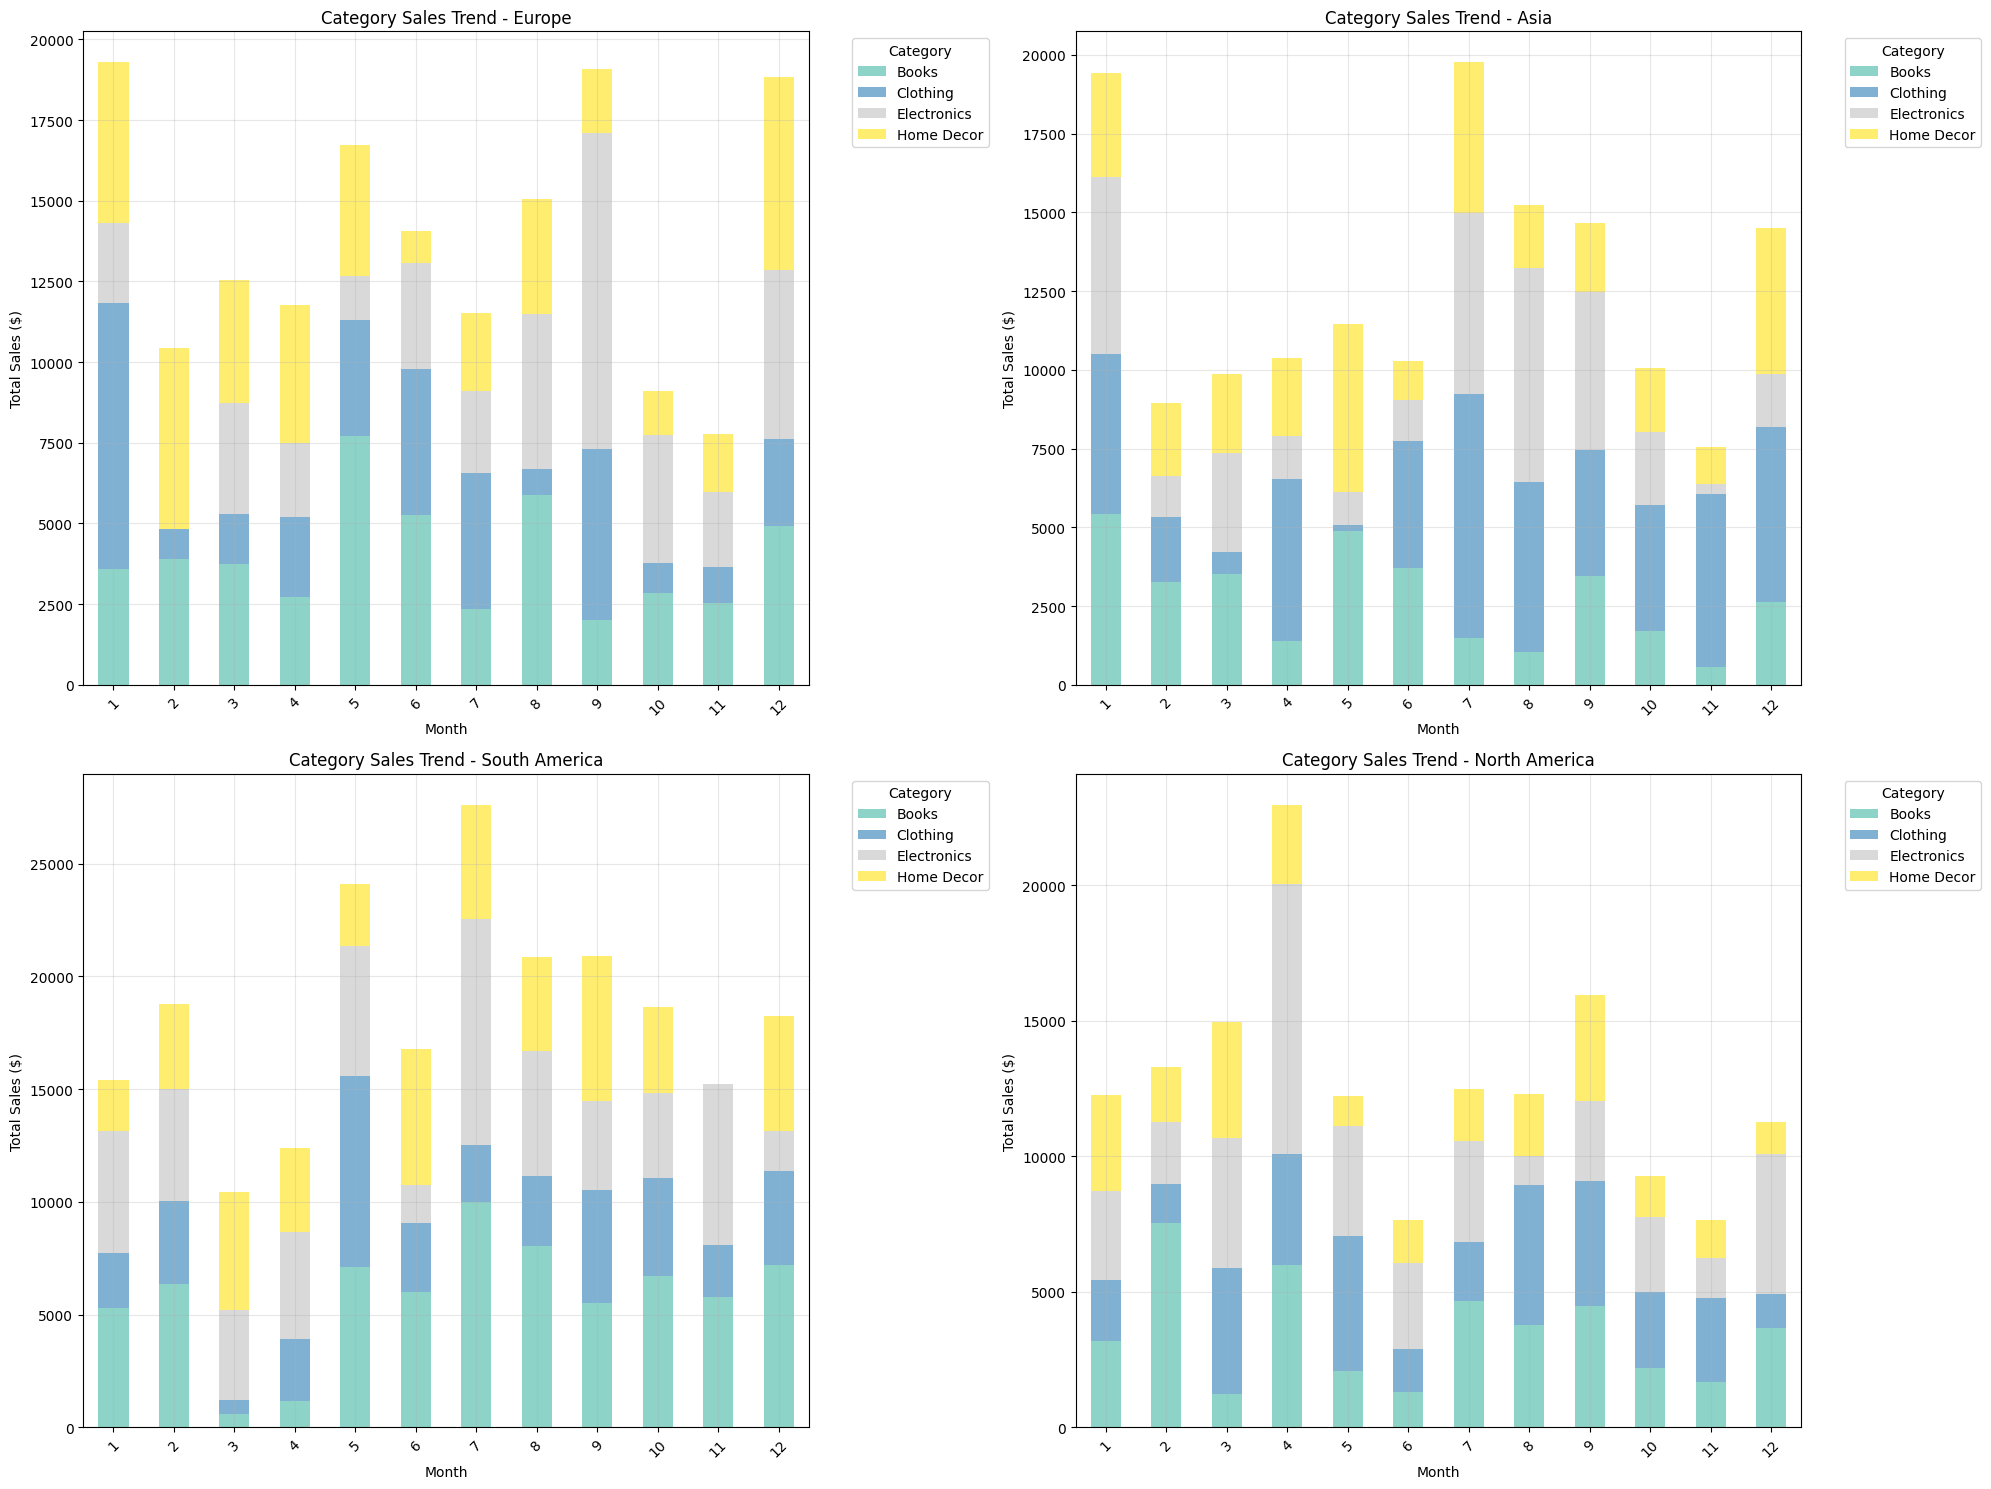

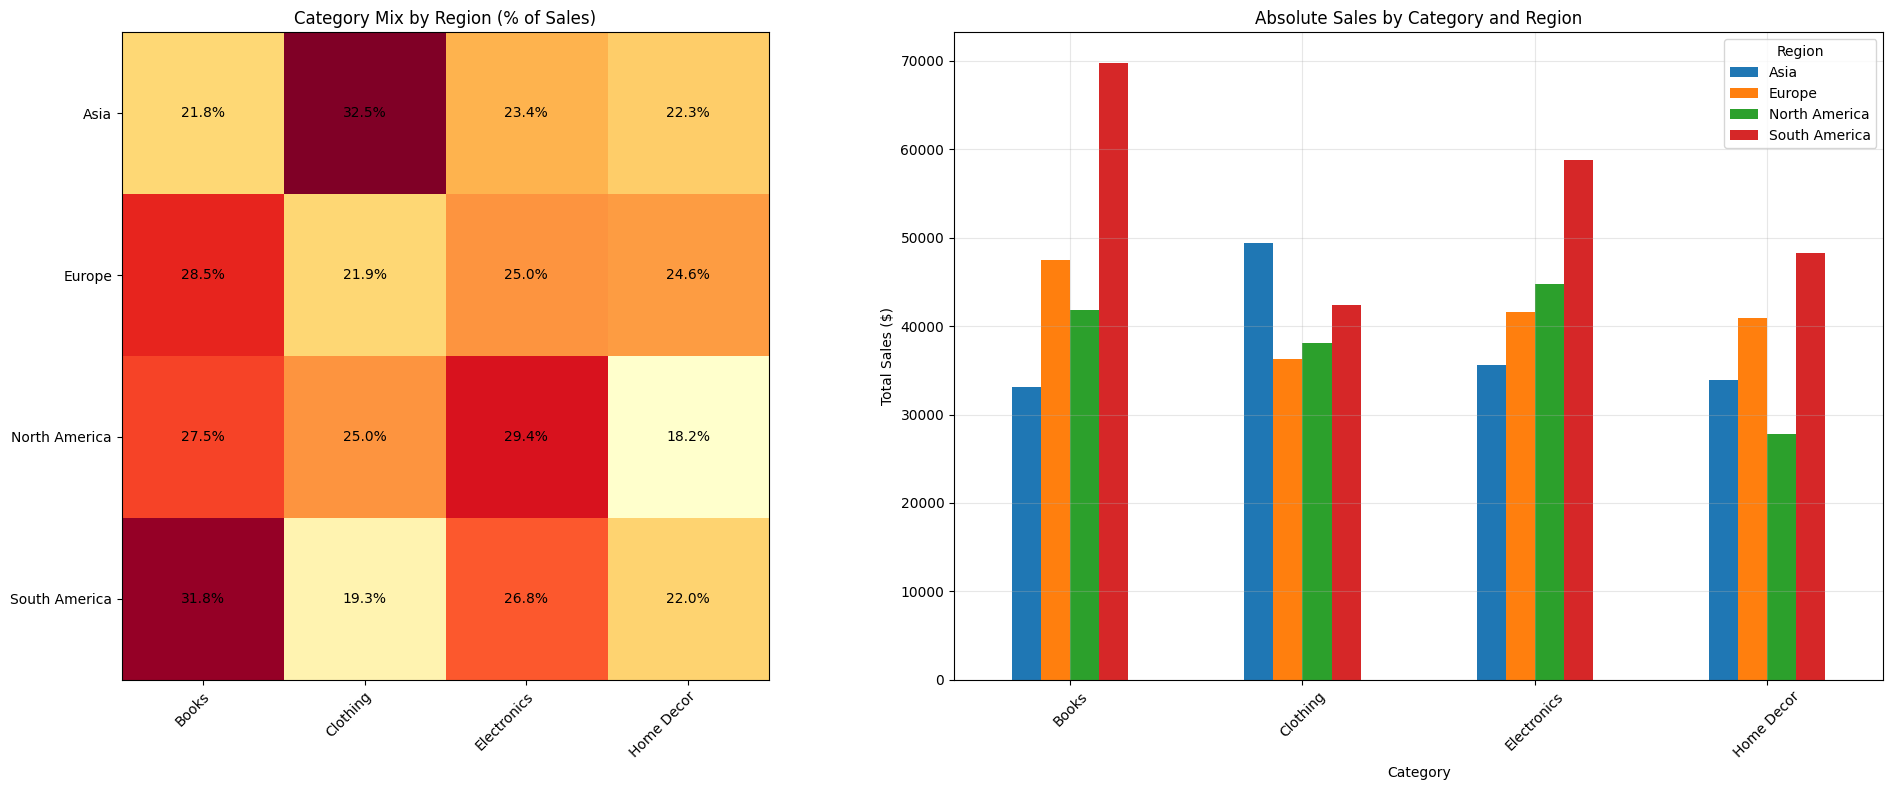

In [13]:
data_frame = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

data_frame['TransactionDate'] = pd.to_datetime(data_frame['TransactionDate'])
data_frame['MonthNum'] = data_frame['TransactionDate'].dt.month
data_frame['MonthLabel'] = data_frame['TransactionDate'].dt.strftime('%b')

def generate_category_analysis():
    category_trends = data_frame.groupby(['Region', 'MonthNum', 'Category']).agg({
        'TotalValue': 'sum',
        'TransactionID': 'count'
    }).reset_index()

    category_trends['MonthLabel'] = category_trends['MonthNum'].map(lambda x: month_abbr[x])

    category_distribution = data_frame.groupby(['Region', 'Category']).agg({
        'TotalValue': 'sum',
        'Quantity': 'sum'
    }).reset_index()

    total_sales_by_region = category_distribution.groupby('Region')['TotalValue'].sum().reset_index()
    category_distribution = category_distribution.merge(total_sales_by_region, on='Region', suffixes=('', '_total'))
    category_distribution['SalesPercentage'] = (category_distribution['TotalValue'] / category_distribution['TotalValue_total'] * 100)

    return category_trends, category_distribution

def create_charts(category_trends, category_distribution):
    figure = plt.figure(figsize=(20, 15))
    ax1 = plt.subplot(221)
    regions_list = data_frame['Region'].unique()
    color_palette = plt.cm.Set3(np.linspace(0, 1, len(data_frame['Category'].unique())))

    for index, region in enumerate(regions_list):
        region_specific_data = category_trends[category_trends['Region'] == region]
        pivot_chart_data = region_specific_data.pivot(index='MonthNum', columns='Category', values='TotalValue')
        ax = plt.subplot(2, 2, index+1)
        pivot_chart_data.plot(kind='bar', stacked=True, ax=ax, color=color_palette)
        ax.set_title(f'Category Sales Trend - {region}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Total Sales ($)')
        ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    figure2, ax2 = plt.subplots(1, 2, figsize=(20, 8))
    heatmap_data = category_distribution.pivot(index='Region', columns='Category', values='SalesPercentage')
    image = ax2[0].imshow(heatmap_data, cmap='YlOrRd')

    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            text = ax2[0].text(j, i, f'{heatmap_data.iloc[i, j]:.1f}%',
                           ha="center", va="center", color="black")

    ax2[0].set_xticks(np.arange(len(heatmap_data.columns)))
    ax2[0].set_yticks(np.arange(len(heatmap_data.index)))
    ax2[0].set_xticklabels(heatmap_data.columns)
    ax2[0].set_yticklabels(heatmap_data.index)
    plt.setp(ax2[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax2[0].set_title('Category Mix by Region (% of Sales)')

    category_sales_chart = category_distribution.pivot(index='Category', columns='Region', values='TotalValue')
    category_sales_chart.plot(kind='bar', ax=ax2[1])
    ax2[1].set_title('Absolute Sales by Category and Region')
    ax2[1].set_xlabel('Category')
    ax2[1].set_ylabel('Total Sales ($)')
    ax2[1].legend(title='Region')
    ax2[1].grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    plt.tight_layout()

    return figure, figure2

def compute_insights(category_trends, category_distribution):
    insights_summary = {
        'Top Category by Region': category_distribution.sort_values('TotalValue', ascending=False)
                                .groupby('Region').first()[['Category', 'TotalValue']]
                                .to_dict('index'),
        'Most Stable Category': category_trends.groupby('Category')['TotalValue']
                                  .std().idxmin(),
        'Fastest Growing Category': category_trends.groupby(['Category', 'MonthNum'])['TotalValue']
                                 .sum().reset_index()
                                 .sort_values('TotalValue', ascending=False)['Category'].iloc[0],
        'Regional Category Distribution': category_distribution.groupby('Region')
                               .apply(lambda x: x.nlargest(3, 'SalesPercentage')['Category'].tolist())
                               .to_dict()
    }
    return insights_summary

category_trends, category_distribution = generate_category_analysis()
fig1, fig2 = create_charts(category_trends, category_distribution)
insights_summary = compute_insights(category_trends, category_distribution)

print("\nKey Business Insights:")
print("\n1. Leading Categories by Region:")
for region, details in insights_summary['Top Category by Region'].items():
    print(f"{region}: {details['Category']} (${details['TotalValue']:,.2f})")

print(f"\n2. Most Stable Category (Lowest Sales Variability): {insights_summary['Most Stable Category']}")
print(f"\n3. Fastest Growing Category: {insights_summary['Fastest Growing Category']}")

print("\n4. Top 3 Categories by Region (% of Sales):")
for region, category_list in insights_summary['Regional Category Distribution'].items():
    print(f"{region}: {', '.join(category_list)}")


<h3>Find the region-wise peak shopping hour</h3>

<ipython-input-14-a89fc9f3ec4f>:110: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['TransactionID'].idxmax(), 'Hour'])



Key Shopping Pattern Insights:

1. Overall Peak Shopping Hour: 14:00

2. Busiest Shopping Day: Tuesday

3. Peak Shopping Hours by Region:
   Asia: 3:00
   Europe: 16:00
   North America: 1:00
   South America: 14:00

4. Hour with Highest Average Transaction Value: 16:00

5. Peak Shopping Month by Region:
   Asia: ('Asia', 'Jan')
   Europe: ('Europe', 'Jan')
   North America: ('North America', 'Apr')
   South America: ('South America', 'Jul')


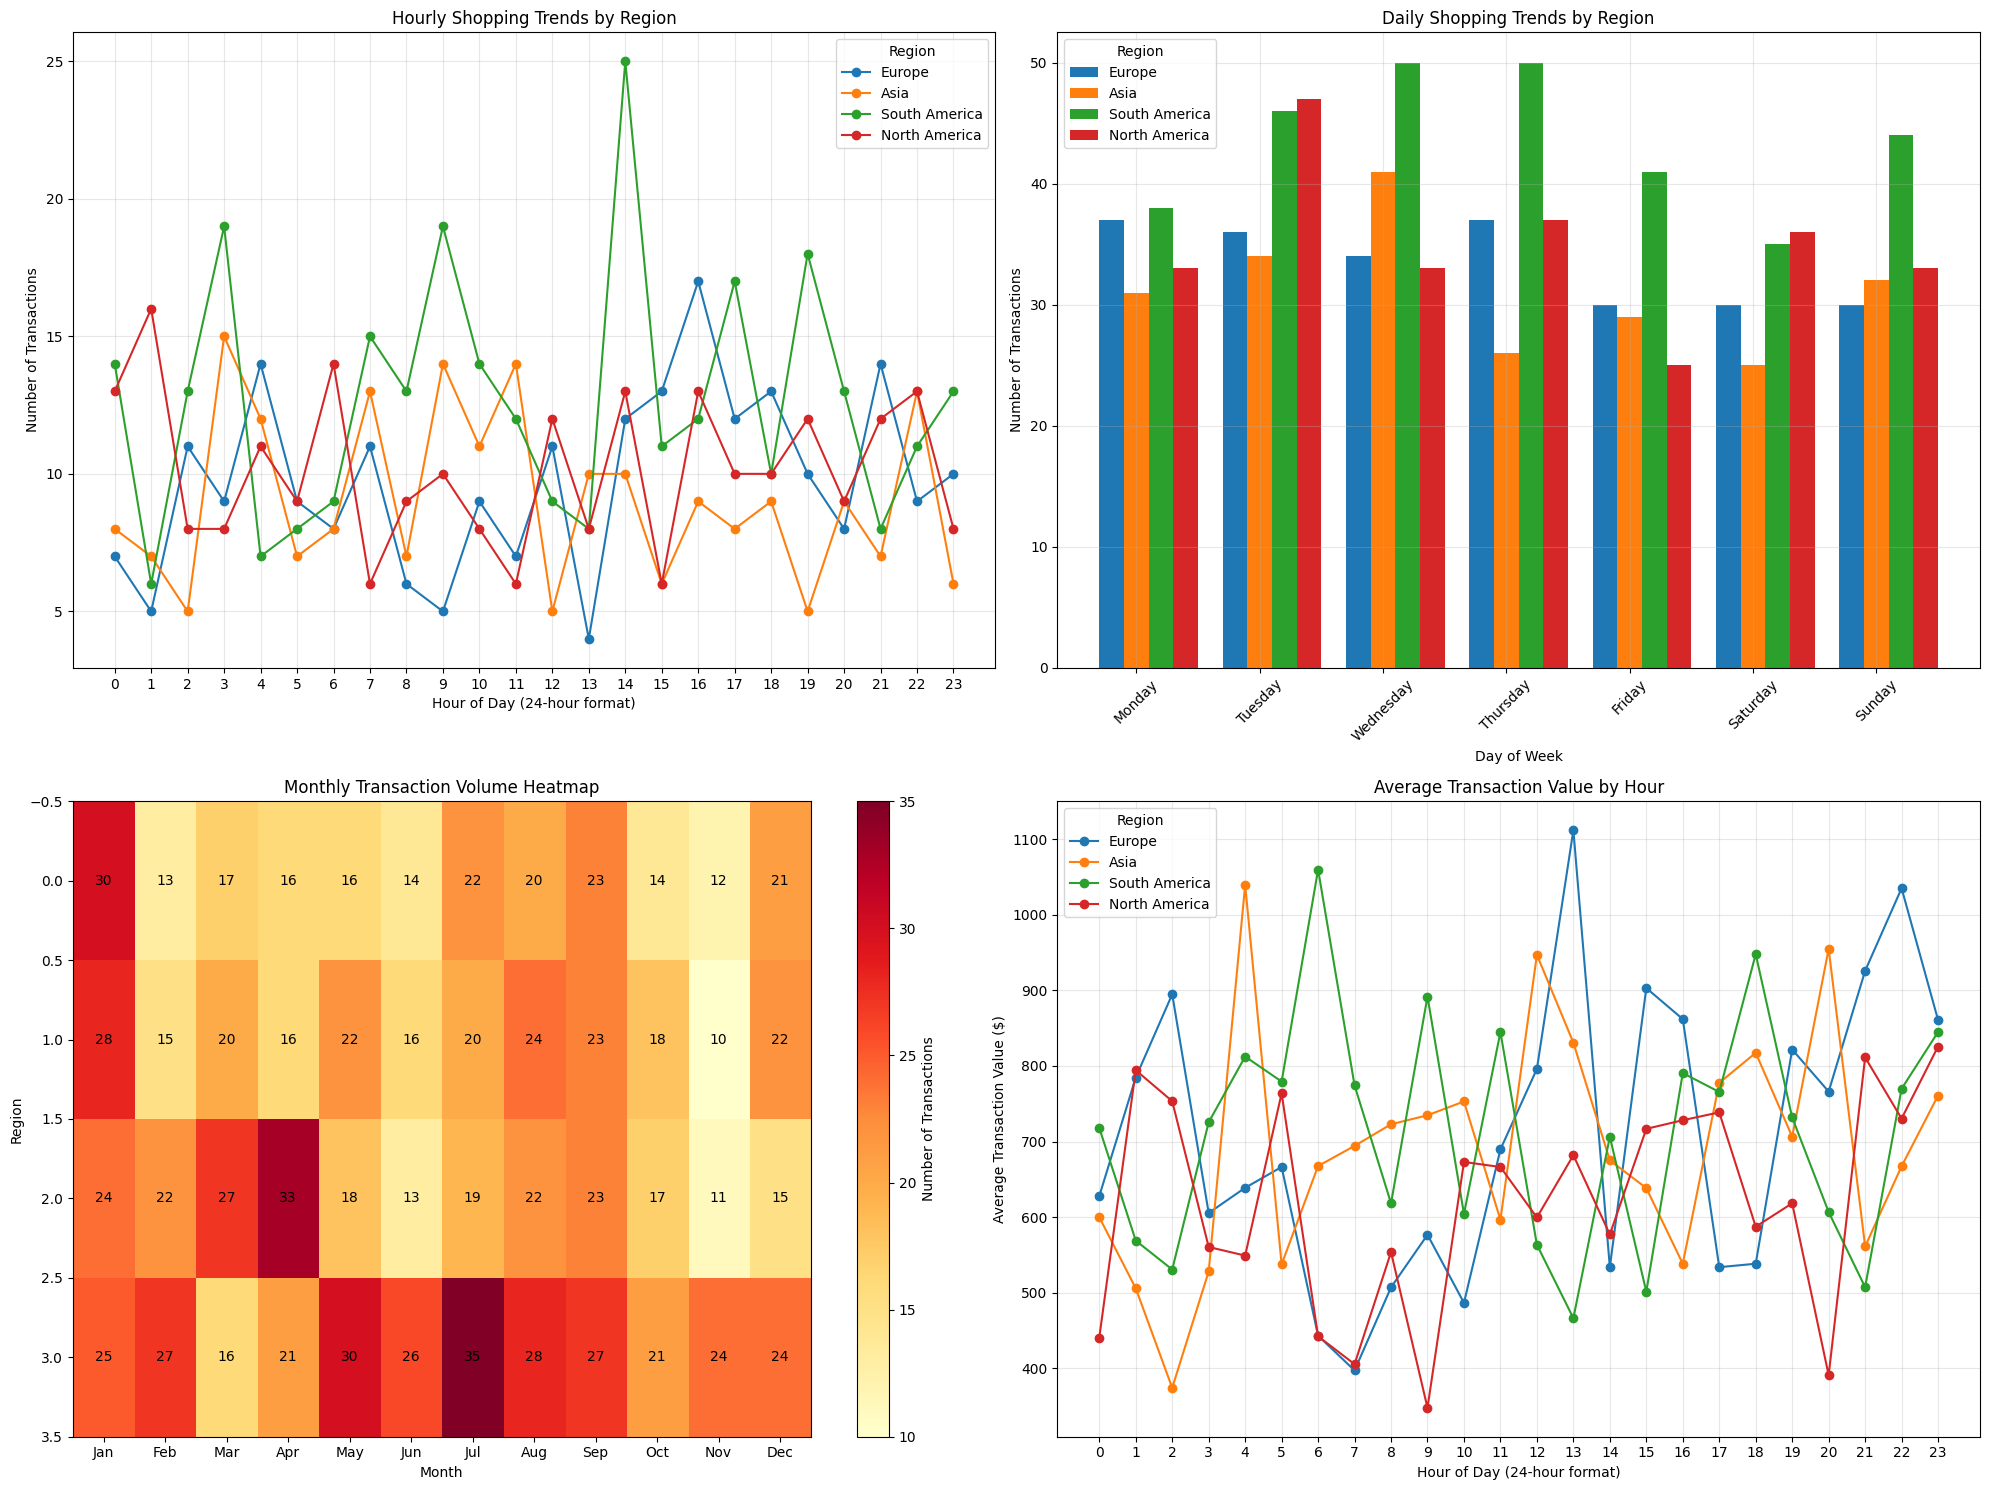

In [14]:
data_frame = transactions.merge(customers, on='CustomerID')

data_frame['TransactionDate'] = pd.to_datetime(data_frame['TransactionDate'])

data_frame['Hour'] = data_frame['TransactionDate'].dt.hour
data_frame['DayOfWeekNum'] = data_frame['TransactionDate'].dt.dayofweek
data_frame['MonthNum'] = data_frame['TransactionDate'].dt.month
data_frame['Year'] = data_frame['TransactionDate'].dt.year
data_frame['DayLabel'] = data_frame['TransactionDate'].dt.day_name()
data_frame['MonthLabel'] = data_frame['TransactionDate'].dt.strftime('%b')

def analyze_shopping_patterns():
    hourly_trends = data_frame.groupby(['Region', 'Hour']).agg({
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).reset_index()

    daily_trends = data_frame.groupby(['Region', 'DayOfWeekNum', 'DayLabel']).agg({
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).reset_index()

    monthly_trends = data_frame.groupby(['Region', 'MonthNum', 'MonthLabel']).agg({
        'TransactionID': 'count',
        'TotalValue': 'sum'
    }).reset_index()

    return hourly_trends, daily_trends, monthly_trends

def create_charts(hourly_trends, daily_trends, monthly_trends):
    plt.style.use('default')

    figure = plt.figure(figsize=(20, 15))

    ax1 = plt.subplot(221)
    for region in data_frame['Region'].unique():
        region_data = hourly_trends[hourly_trends['Region'] == region]
        ax1.plot(region_data['Hour'],
                region_data['TransactionID'],
                marker='o',
                label=region)

    ax1.set_title('Hourly Shopping Trends by Region')
    ax1.set_xlabel('Hour of Day (24-hour format)')
    ax1.set_ylabel('Number of Transactions')
    ax1.grid(True, alpha=0.3)
    ax1.legend(title='Region')
    ax1.set_xticks(range(0, 24))

    ax2 = plt.subplot(222)
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    width = 0.8 / len(data_frame['Region'].unique())

    for idx, region in enumerate(data_frame['Region'].unique()):
        region_data = daily_trends[daily_trends['Region'] == region]
        x = np.arange(len(days)) + idx * width
        ax2.bar(x, region_data['TransactionID'], width, label=region)

    ax2.set_title('Daily Shopping Trends by Region')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_xticks(np.arange(len(days)) + width)
    ax2.set_xticklabels(days, rotation=45)
    ax2.grid(True, alpha=0.3)
    ax2.legend(title='Region')

    ax3 = plt.subplot(223)
    heatmap_data = monthly_trends.pivot(index='Region',
                                         columns='MonthNum',
                                         values='TransactionID')
    im = ax3.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')

    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            text = ax3.text(j, i, f'{heatmap_data.iloc[i, j]:.0f}',
                          ha="center", va="center", color="black")

    ax3.set_title('Monthly Transaction Volume Heatmap')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Region')
    ax3.set_xticks(range(12))
    ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.colorbar(im, ax=ax3, label='Number of Transactions')

    ax4 = plt.subplot(224)
    for region in data_frame['Region'].unique():
        region_data = hourly_trends[hourly_trends['Region'] == region]
        avg_value = region_data['TotalValue'] / region_data['TransactionID']
        ax4.plot(region_data['Hour'],
                avg_value,
                marker='o',
                label=region)

    ax4.set_title('Average Transaction Value by Hour')
    ax4.set_xlabel('Hour of Day (24-hour format)')
    ax4.set_ylabel('Average Transaction Value ($)')
    ax4.grid(True, alpha=0.3)
    ax4.legend(title='Region')
    ax4.set_xticks(range(0, 24))

    plt.tight_layout()
    return figure

def compute_insights(hourly_trends, daily_trends, monthly_trends):
    insights_summary = {
        'Peak Hour': hourly_trends.groupby('Hour')['TransactionID'].sum().idxmax(),
        'Busiest Day': daily_trends.groupby('DayLabel')['TransactionID'].sum().idxmax(),
        'Regional Peak Hours': hourly_trends.groupby(['Region'])
                             .apply(lambda x: x.loc[x['TransactionID'].idxmax(), 'Hour'])
                             .to_dict(),
        'Highest Value Hour': hourly_trends.groupby('Hour')
                             ['TotalValue'].mean().idxmax(),
        'Peak Shopping Month by Region': monthly_trends.groupby(['Region', 'MonthLabel'])
                        ['TransactionID'].sum().groupby('Region').idxmax().to_dict()
    }
    return insights_summary

hourly_trends, daily_trends, monthly_trends = analyze_shopping_patterns()
fig = create_charts(hourly_trends, daily_trends, monthly_trends)
insights_summary = compute_insights(hourly_trends, daily_trends, monthly_trends)

print("\nKey Shopping Pattern Insights:")
print(f"\n1. Overall Peak Shopping Hour: {insights_summary['Peak Hour']}:00")
print(f"\n2. Busiest Shopping Day: {insights_summary['Busiest Day']}")
print("\n3. Peak Shopping Hours by Region:")
for region, hour in insights_summary['Regional Peak Hours'].items():
    print(f"   {region}: {hour}:00")
print(f"\n4. Hour with Highest Average Transaction Value: {insights_summary['Highest Value Hour']}:00")
print("\n5. Peak Shopping Month by Region:")
for region, month in insights_summary['Peak Shopping Month by Region'].items():
    print(f"   {region}: {month}")


<h3>Find Frequent v/s Occasional Buyers</h3>

<ipython-input-15-947e95dbca65>:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_spend = customer_metrics.groupby('Segment')['TotalSpend'].mean()
<ipython-input-15-947e95dbca65>:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'segment_stats': customer_metrics.groupby('Segment').agg({
<ipython-input-15-947e95dbca65>:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'spend_by_segment': customer_metrics.groupby('Se


Customer Purchase Frequency Analysis:

Total Customers: 199

Segment Statistics:

Scarce Buyers:
Count: 67.0
Average Transactions: 4.0
Average Total Spend: $2,757.52
Average Purchase Frequency: 0.44 purchases/month
Average Days Between Purchases: 72.3 days

Regular Buyers:
Count: 65.0
Average Transactions: 5.5
Average Total Spend: $3,865.77
Average Purchase Frequency: 0.68 purchases/month
Average Days Between Purchases: 44.8 days

Frequent Buyers:
Count: 67.0
Average Transactions: 5.6
Average Total Spend: $3,790.54
Average Purchase Frequency: 6.47 purchases/month
Average Days Between Purchases: 23.3 days

Purchase Frequency Percentiles (purchases/month):
mean: 2.55
min: 0.20
25%: 0.49
50%: 0.68
75%: 0.92
90%: 1.43
95%: 30.00
max: 30.00

Total Spend by Segment:
Scarce: $184,753.95
Regular: $251,275.31
Frequent: $253,966.30


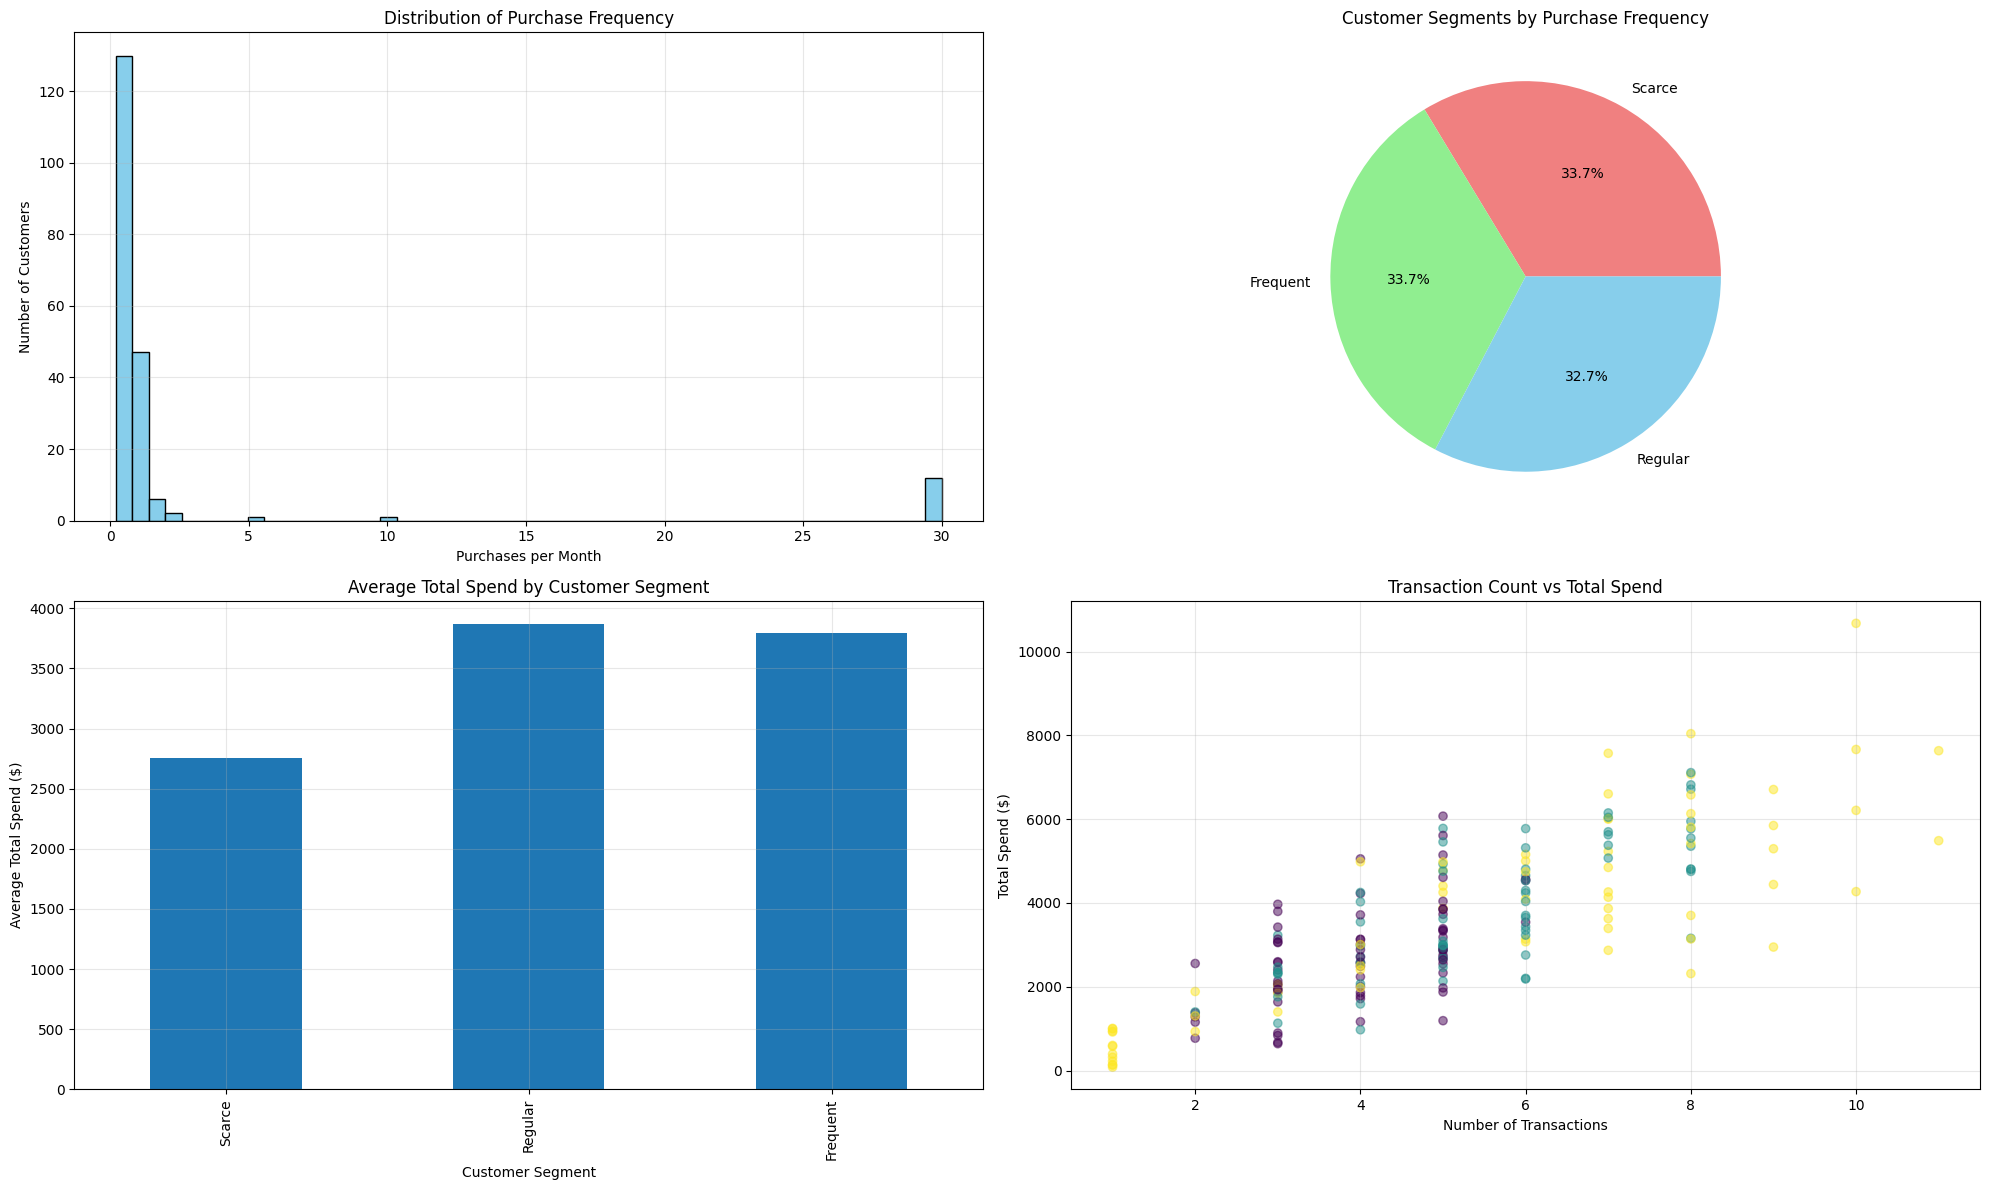

In [15]:
def load_and_validate_data():
    try:
        customers = pd.read_csv('Customers.csv')
        transactions = pd.read_csv('Transactions.csv')
        required_columns = {
            'customers': ['CustomerID', 'Region'],
            'transactions': ['TransactionID', 'CustomerID', 'TransactionDate', 'TotalValue']
        }

        for df_name, columns in required_columns.items():
            df = locals()[df_name]
            missing_cols = [col for col in columns if col not in df.columns]
            if missing_cols:
                raise KeyError(f"Missing columns in {df_name}: {missing_cols}")

        df = transactions.merge(customers, on='CustomerID', how='left')

        df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def analyze_purchase_frequency(df):
    if df is None:
        return None

    try:
        customer_metrics = df.groupby('CustomerID').agg({
            'TransactionID': 'count',  # Number of transactions
            'TotalValue': 'sum',      # Total spend
            'TransactionDate': lambda x: (x.max() - x.min()).days + 1  # Active period
        }).reset_index()

        customer_metrics.columns = ['CustomerID', 'TransactionCount', 'TotalSpend', 'ActiveDays']

        customer_metrics['AvgDaysBetweenPurchases'] = customer_metrics['ActiveDays'] / customer_metrics['TransactionCount']

        customer_metrics['PurchaseFrequency'] = (customer_metrics['TransactionCount'] /
                                               (customer_metrics['ActiveDays'] / 30))

        customer_metrics['Segment'] = pd.qcut(customer_metrics['PurchaseFrequency'],
                                            q=3,
                                            labels=['Scarce', 'Regular', 'Frequent'])

        return customer_metrics
    except Exception as e:
        print(f"Error analyzing purchase frequency: {e}")
        return None

def create_visualizations(customer_metrics):
    if customer_metrics is None:
        return None

    try:
        fig = plt.figure(figsize=(20, 12))

        ax1 = plt.subplot(221)
        plt.hist(customer_metrics['PurchaseFrequency'], bins=50, color='skyblue', edgecolor='black')
        plt.title('Distribution of Purchase Frequency')
        plt.xlabel('Purchases per Month')
        plt.ylabel('Number of Customers')
        plt.grid(True, alpha=0.3)

        ax2 = plt.subplot(222)
        segment_counts = customer_metrics['Segment'].value_counts()
        plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%',
                colors=['lightcoral', 'lightgreen', 'skyblue'])
        plt.title('Customer Segments by Purchase Frequency')

        ax3 = plt.subplot(223)
        avg_spend = customer_metrics.groupby('Segment')['TotalSpend'].mean()
        avg_spend.plot(kind='bar')
        plt.title('Average Total Spend by Customer Segment')
        plt.xlabel('Customer Segment')
        plt.ylabel('Average Total Spend ($)')
        plt.grid(True, alpha=0.3)

        ax4 = plt.subplot(224)
        plt.scatter(customer_metrics['TransactionCount'],
                   customer_metrics['TotalSpend'],
                   alpha=0.5, c=customer_metrics['Segment'].astype('category').cat.codes)
        plt.title('Transaction Count vs Total Spend')
        plt.xlabel('Number of Transactions')
        plt.ylabel('Total Spend ($)')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig
    except Exception as e:
        print(f"Error creating visualizations: {e}")
        return None

def calculate_insights(customer_metrics):
    if customer_metrics is None:
        return None

    try:
        insights = {
            'segment_stats': customer_metrics.groupby('Segment').agg({
                'CustomerID': 'count',
                'TransactionCount': ['mean', 'median'],
                'TotalSpend': ['mean', 'median'],
                'AvgDaysBetweenPurchases': ['mean', 'median'],
                'PurchaseFrequency': ['mean', 'median']
            }),

            'total_customers': len(customer_metrics),

            'frequency_percentiles': customer_metrics['PurchaseFrequency'].describe(
                percentiles=[.25, .5, .75, .9, .95]
            ),

            'spend_by_segment': customer_metrics.groupby('Segment')['TotalSpend'].sum()
        }
        return insights
    except Exception as e:
        print(f"Error calculating insights: {e}")
        return None

def main():
    df = load_and_validate_data()
    customer_metrics = analyze_purchase_frequency(df)
    if customer_metrics is None:
        return

    fig = create_visualizations(customer_metrics)
    insights = calculate_insights(customer_metrics)
    if insights is None:
        return

    print("\nCustomer Purchase Frequency Analysis:")
    print(f"\nTotal Customers: {insights['total_customers']}")

    print("\nSegment Statistics:")
    for segment in ['Scarce', 'Regular', 'Frequent']:
        stats = insights['segment_stats'].xs(segment)
        print(f"\n{segment} Buyers:")
        print(f"Count: {stats['CustomerID']['count']}")
        print(f"Average Transactions: {stats['TransactionCount']['mean']:.1f}")
        print(f"Average Total Spend: ${stats['TotalSpend']['mean']:,.2f}")
        print(f"Average Purchase Frequency: {stats['PurchaseFrequency']['mean']:.2f} purchases/month")
        print(f"Average Days Between Purchases: {stats['AvgDaysBetweenPurchases']['mean']:.1f} days")

    print("\nPurchase Frequency Percentiles (purchases/month):")
    for percentile, value in insights['frequency_percentiles'].items():
        if percentile not in ['count', 'std']:
            print(f"{percentile}: {value:.2f}")

    print("\nTotal Spend by Segment:")
    for segment, spend in insights['spend_by_segment'].items():
        print(f"{segment}: ${spend:,.2f}")

if __name__ == "__main__":
    main()
